In [371]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
import numpy as np

## Goal
- I'm going to focus on finding out what KPI's are most important for increasing `Opportunity Created`

## Analysis

In [372]:
data = pd.read_csv("data/monthly_report_expanded.csv")

### Wrangling Data
- Here I am combining the 'last month' and 'month before last' columns for each feature
- Time series isn't the best fit here, since there are just 2 time related data points per feature, so I'm just going to ignore the months and use the data all as one

In [373]:
last_month = data.iloc[:, :16]
month_before_last = pd.concat([data.iloc[:, 0], data.iloc[:, 16:]], axis=1)

col_names = [x[:-13] for x in data.columns[1:16]]
last_month["month"] = [0] * len(last_month)
last_month.columns = ["user_name"] + col_names + ["month"]
month_before_last["month"] = [1] * len(month_before_last)
month_before_last.columns = ["user_name"] + col_names + ["month"]

data = pd.concat([last_month, month_before_last], axis=0).sort_values(by=["user_name", "month"]).reset_index(drop=True)

### EDA Visualization
- This is a correlation heatmap
- It gives me an idea of which features are most related to `Opportunity Created`

<Axes: >

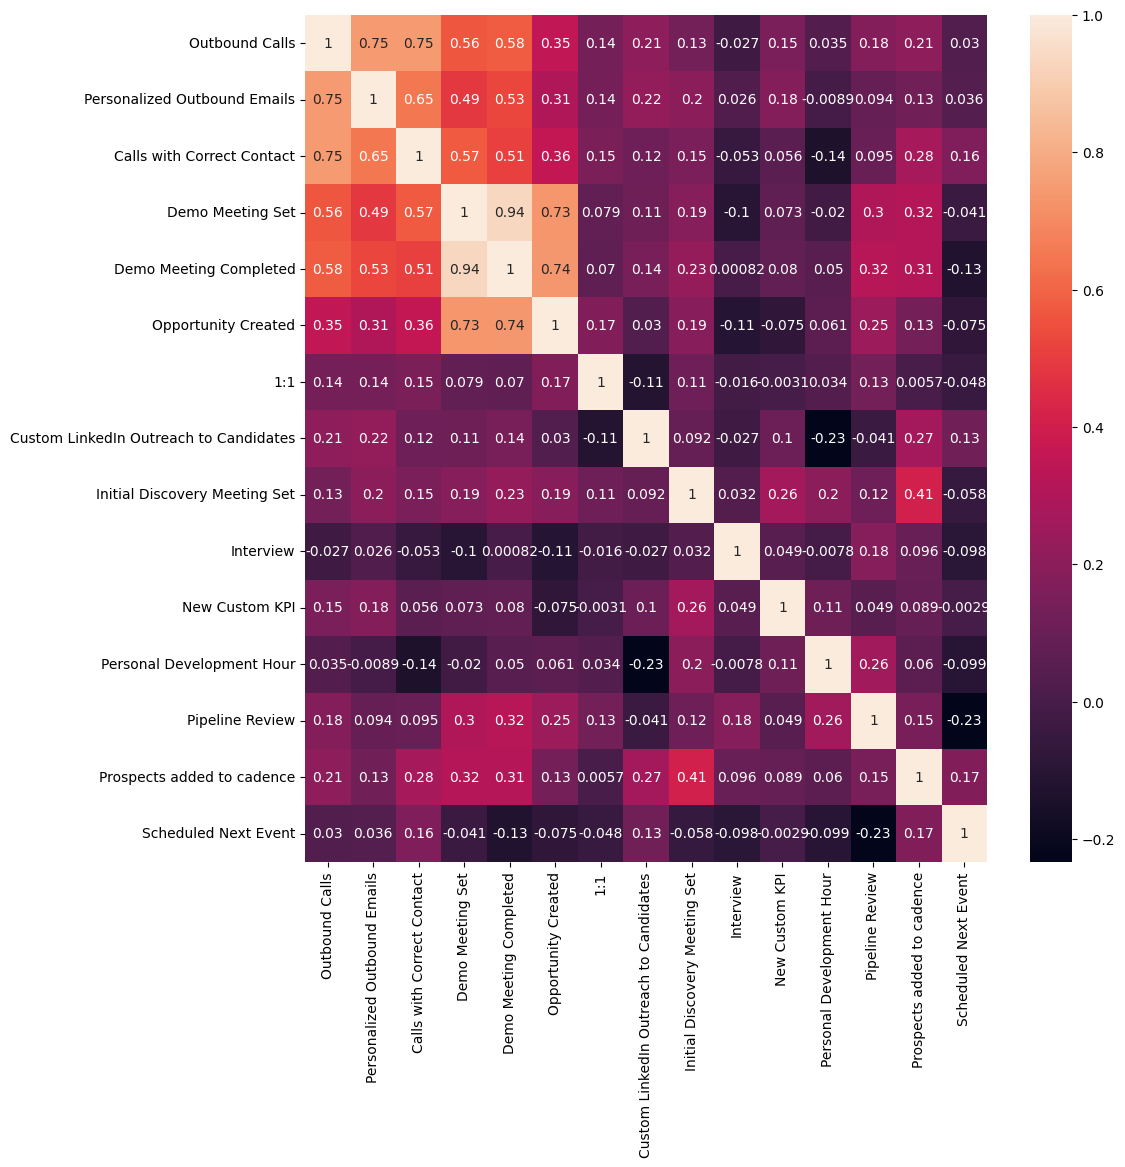

In [374]:
plt.figure(figsize=(11, 11))
sns.heatmap(data.iloc[:, 1:16].corr(), annot=True)

### Feature Importance
- Here I use Lasso Regression to find the importance of features in predicting `Opportunity Created`
- Lasso Regression is useful for this because it will disclude unimportant features automatically and focus only on relevant ones.

In [375]:
y_opp = data["Opportunity Created"]
x_opp = data[data.iloc[:, 1:16].columns.difference(["Opportunity Created"])]

lasso_opp = LassoCV(random_state=43)
lasso_opp.fit(x_opp, y_opp)
y_pred = lasso_opp.predict(x_opp)
mae = np.abs((y_opp.values - y_pred)).mean()
print(f"Model Mean Absolute Error: {round(mae, 3)}")

Model Mean Absolute Error: 0.377


#### Model Evaluation
- The Mean Absolute Error (MAE) of a regression model reflects on average how incorrect the model is in the units it is predicting
- The MAE of the model predicting `Opportunity Created` is 0.377, so on average the model will be incorrect in predicting `Opportunity Created` by +/- 0.377.
- Normally it would be a good idea to do a train test split to ensure the model generalizes well (aka performs well on data it hasn't seen before). I am getting around that by using a model that does cross validation. But a train test split would still be a good idea

##### Residual Plot
- This is a way to check a regression model, the desired plot is basically a uniform blob.

Text(0, 0.5, 'Residuals')

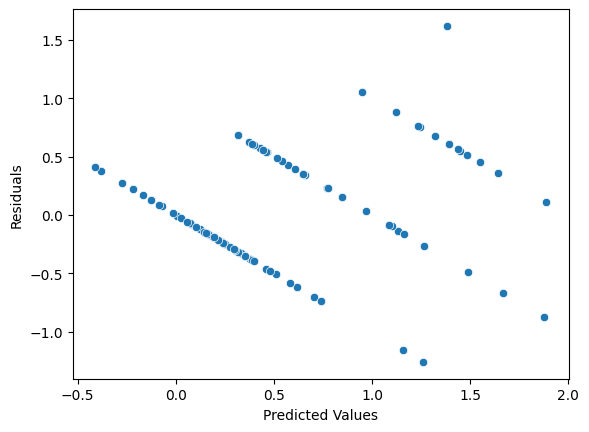

In [376]:
residuals = y_opp - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

- Note: The plot has those lines because the only values for `Opportunity Created` are 0, 1, 2, and 3

/tmp/ipykernel_303246/3029034131.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)


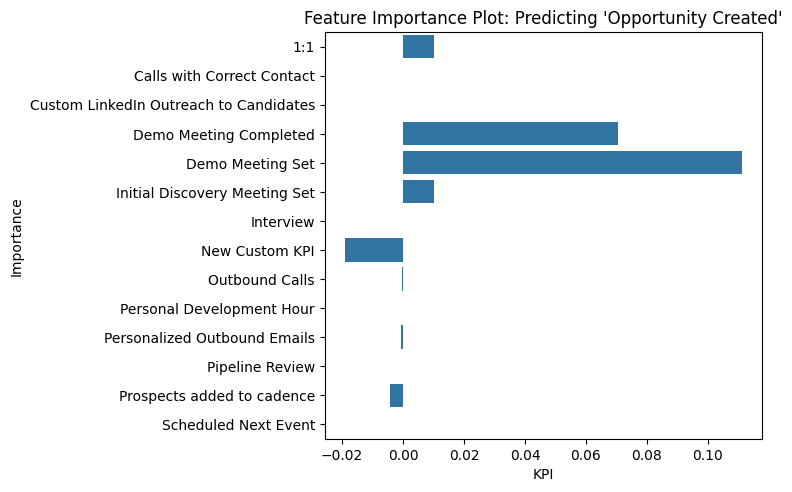

In [377]:
feature_coeff = lasso_opp.coef_
feature_weights = pd.DataFrame({
    "feature": x_opp.columns,
    "weight": feature_coeff
})
ax = sns.barplot(
    feature_weights,
    y = "feature",
    x = "weight",
    orient="h"
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)
plt.tight_layout()
ax.set_xlabel("KPI")
ax.set_ylabel("Importance")
ax.tick_params(axis='y', labelsize=10)
plt.title("Feature Importance Plot: Predicting 'Opportunity Created'")
plt.show()

- Note: The feature importance values are relative, they don't have any unit (like percentage, etc.)

#### Results
- It looks like `Demo Meeting Completed` and `Demo Meeting Set` are the most positively important features to predict `Opportunity Created`
- `New Customer KPI` (whatever that is), seems to be negatively impacting `Opportunity Created`, that could be true, or it could just be a coincidence because of their relationship, warrants further investigation.
- A takeaway from this could then be to tell salespeople to increase Demo Meetings and make sure they complete them. But, what helps them increase Demo Meetings?

### Digging Deeper
- Since `Demo Meeting Set` is the most important, we're going to do the same analysis we just did, but for which features best predict `Demo Meeting Set` (Purposely not including Opportunity Created or Demo Meeting Completed)
- This will hopefully tell us which actions are most important for increasing Demos
- We can skip right to the Feature Importance plot

In [378]:
y_demo = data["Demo Meeting Set"]
x_demo = data[data.iloc[:, 1:16].columns.difference(["Opportunity Created", "Demo Meeting Set", "Demo Meeting Completed"])]
# NOTE: We're not including Opportunity Created, or Demo Meeting Completed

lasso_demo = LassoCV()
lasso_demo.fit(x_demo, y_demo)

y_pred = lasso_demo.predict(x_demo)
mae = np.abs((y_demo.values - y_pred)).mean()
print(f"Model Mean Absolute Error: {round(mae, 3)}")

Model Mean Absolute Error: 2.2


Text(0, 0.5, 'Residuals')

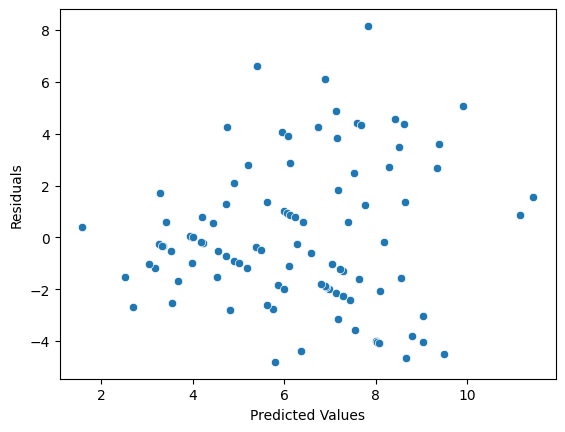

In [379]:
residuals = y_demo - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

/tmp/ipykernel_303246/3537900632.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)


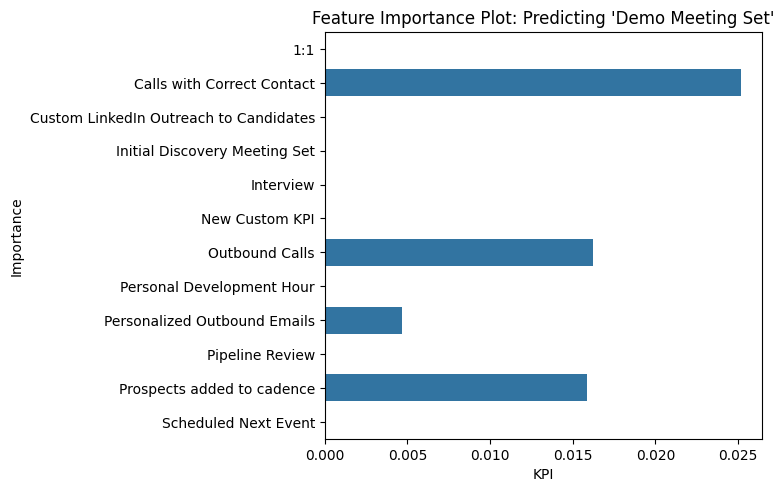

In [380]:
feature_coeff = lasso_demo.coef_
feature_weights = pd.DataFrame({
    "feature": x_demo.columns,
    "weight": feature_coeff
})
ax = sns.barplot(
    feature_weights,
    y = "feature",
    x = "weight",
    orient="h"
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)
plt.tight_layout()
ax.set_xlabel("KPI")
ax.set_ylabel("Importance")
ax.tick_params(axis='y', labelsize=10)
plt.title("Feature Importance Plot: Predicting 'Demo Meeting Set'")
plt.show()

- Note: The feature importance values are relative, they don't have any unit (like percentage, etc.)

#### Feature Importance
- Looks like the features that are important to `Demo Meeting Set` are: `Calls with Correct Contact`, `Outbound Calls`, `Personalized Outbound Emails`, and `Prospects added to cadence`


## Prescriptive Analytics

- Using the models created above we can prescribe actions to increase the desired KPI, `Opportunity Created`

- First we see what it would take to increase the opportunities of a given sales person (Adam Cohen) according to one of his past months.
- If we increase Adam's Demo Meetings Set to 10, it is predicted he will create 1 opportunity

In [381]:
adam_cohen = pd.DataFrame(data.iloc[0, :][x_opp.columns]).transpose()
print(f'Current Number of Opportunties Created: {data.loc[0, "Opportunity Created"]}')

adam_cohen_modified = adam_cohen.copy(deep=True)
adam_cohen_modified.loc[0, "Demo Meeting Set"] += 5

pred_opp_modified = lasso_opp.predict(adam_cohen_modified)
print(f'Predicted Number of Opportunities Created With 10 Demo Meetings Set: {round(pred_opp_modified[0])}')

Current Number of Opportunties Created: 0
Predicted Number of Opportunities Created With 10 Demo Meetings Set: 1


- So the question is, what would we have to do to increase his Demo Meetings Set to 10?
- We can use the second regression model to determine what increases are needed

In [388]:
adam_cohen_demo = pd.DataFrame(data.iloc[0, :][x_demo.columns]).transpose()
print(f'Current Number of Demo Meetings Set: {data.loc[0, "Demo Meeting Set"]}')

adam_cohen_demo_modified = adam_cohen_demo.copy(deep=True)
adam_cohen_demo_modified.loc[0, "Calls with Correct Contact"] += 50
adam_cohen_demo_modified.loc[0, "Outbound Calls"] += 70
adam_cohen_demo_modified.loc[0, "Personalized Outbound Emails"] += 70

pred_demo_modified = lasso_demo.predict(adam_cohen_demo_modified)
print(f'Predicted Number of Demo Meetings Set With Increased Activities: {round(pred_demo_modified[0])}')

Current Number of Demo Meetings Set: 5
Predicted Number of Demo Meetings Set With Increased Activities: 10


- The sales person would likely know best which activities they can reasonably increase, so it would be appropriate for them to be able to select what activities they want to increase, or set limits on how high certain things can go